In [1]:
import os
import sys
import random
from collections import Counter
import Levenshtein

import numpy as np
import matplotlib.pyplot as plt


In [2]:
extender = ['AGT', 'GT', 'T', '']

In [3]:
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 
              'U': 'A', 'R': 'Y', 'Y': 'R', 'M': 'K', 
              'K': 'M', 'B': 'V', 'V': 'B', 'D': 'H', 
              'H': 'D'}

def rev_complement(seq, comp_dic = complement):
    return "".join(comp_dic.get(base, base) for base in reversed(seq))

In [4]:
def load_edit_coad(length, levensthein_distance):
    with open('./DNA_Edit_Barcodes', 'r') as f:
        flag = 0
        data = []
        for line in f:
            if line.strip() == '' and flag == 1:
                return data
            if flag == 1:
                data.append(line.strip().split(':')[1])
            if line.strip() == '[{}nt ed{}]'.format(length, levensthein_distance):
                flag = 1   
        if flag == 0:
            print('[{}nt ed{}] was no  found in file'.format(length, levensthein_distance))
            return data
    return data

removed AAGGCGTT AACGCCTT 2
removed CACTAGTC GACTAGTG 2
removed CCTATAGC GCTATAGG 2
removed CGATATCC GGATATCG 2
removed GTGAAGGA TCCTTCAC TCCTTCAC 0
removed TTGCGGAA TTCCGCAA 2
3 GAGTCATC GATGACTC
1 TACGGTGT TACGGTCT
1 TTAAGGCG TTAACGCG
3 CCATTGGA TCCAATGG
3 ACCTGGTT AACCAGGT
1 CCTTACTG CCATACTG
1 AGACCGTA ACACCGTA
1 GCACGTAT GGACGTAT
1 CGCGTTAA CGCCTTAA
1 ATACGTCC ATACGTGC
1 CAGTATGG CAGTAAGG
3 GGTTACAC GTGTAACC
3 TAGGACCT AGGTCCTA
3 GTTCTGAC GTCAGAAC
96


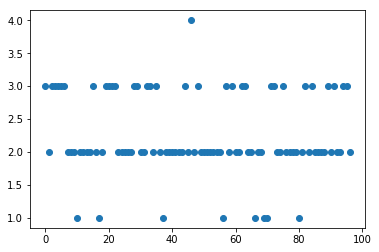

In [5]:
a = load_edit_coad(8,4)

# remove bc which are within 2 edit distance of their complement or complements of other barcodes
bad = []
dist = np.zeros([len(a),len(a)]) + np.inf
for i, bc in enumerate(a):
    for j, bc2 in enumerate(a):
        d = Levenshtein.distance(rev_complement(bc), bc2)
        if d < 1:
            #a.remove(bc2)
            a.remove(bc)
            print('removed', bc,rev_complement(bc), bc2, d)
            bad.append(bc)
        if i == j and d < 3:
            a.remove(bc)
            print('removed', bc2, rev_complement(bc), d)
            bad.append(bc)

a = list(set(a)-set(bad))
  
not_top = []         
for i, bc in enumerate(a):
    for j, bc2 in enumerate(a):
        d = Levenshtein.distance(rev_complement(bc), bc2)
        if (i == j and d==3) or d==1:
            print(d, rev_complement(bc), bc2)
            dist[i,j] = d
            not_top.append(bc)
        else:
            dist[i,j] = d  

a.remove('TCCAATGG') # to much self complementary for my taste

print(len(a))    
plt.plot(np.min(dist, axis=0), 'o')
plt.show()


In [6]:
GC = np.zeros(len(a))
for i, bc in enumerate(a):
    temp = Counter(bc)
    GC[i] = (temp['G'] + temp['C'])/len(bc)
print(np.min(GC))

0.5


In [7]:
#   T7 promoter: TAATACGACTCACTATAGGG, PE2c: AAATGCCGATTCCTGCTGAAC

pBB1 = 'ACTAACAATAAGCTC UAU CGATGACC TAATACGACTCACTATAGGG AC AAATGCCGATTCCTGCTGAAC' # /5Acryd/


In [8]:
def part1(scar0, scar1, ext, BC1):
    return '{} {} {} {}'.format(scar0, ext, BC1, scar1), rev_complement('{} {}'.format(ext, BC1))

def part2(scar1, scar2, BC2):
    return '{}'.format(BC2), rev_complement('{} {} {}'.format(scar1, BC2, scar2))

def part3(scar2, scar3, BC3):
    return '{} {} {}'.format(scar2, BC3, scar3), rev_complement('{}'.format(BC3))

def scar_assembler(scars):
    scar_dist1 = np.zeros([len(scars), len(scars)])
    scar_dist2 = np.zeros([len(scars), len(scars)])
    scars1 = []
    scars2 = []
    for i, sc1 in enumerate(scars):
        for j, sc2 in enumerate(scars):
            scar1 = ''
            for k,l in zip(sc1,sc2[::-1]):
                scar1 += l
                if k==complement[l]:
                    scar_dist1[i,j] += 1
            scars1.append(scar1)
            scar2 = ''
            for k,l in zip(sc1,rev_complement(sc2)[::-1]):
                scar2 += l
                if k==complement[l]:
                    scar_dist2[i,j] += 1
            scars2.append(scar2)
    return scar_dist1, scar_dist2, scars1, scars2

def barcode_from_file(path):
    with open(path, 'r') as f:
        barcodes = [line.split(',')[-1].strip() for line in f][1:]
    return barcodes

('GTCA GAT AGCATGGA AACC', 'TCCATGCT ATC')
('AATGCAGC', 'CTGT GCTGCATT GGTT')
('ACAG AATGCAGC AGGA', 'GCTGCATT') TCCT


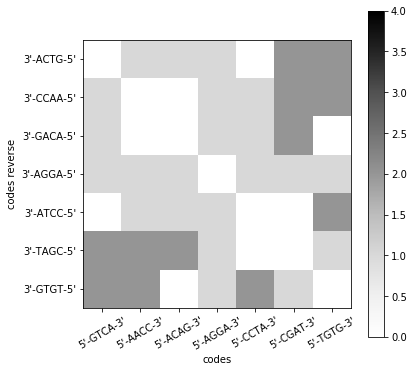

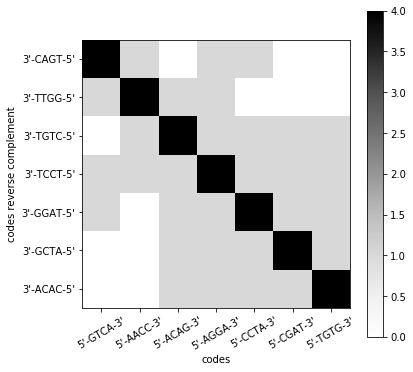

In [9]:


scars = load_edit_coad(4,3)
#scars.remove('CGAT') # might crosstalk 
#scars.remove('TGTG') # might crosstalk 
#scars.remove('AGGA') # worst of the remaining
scars2 = [rev_complement(scars[-1]), 'CGAT', 'TGTG', 'AGGA'] # for cluster beads


d1, d2, sc1, sc2 = scar_assembler(scars)

fig, ax1 = plt.subplots(1,1, figsize=(6,6))
im1 = ax1.imshow(d1, cmap='Greys', vmin=0, vmax=4)
ax1.set_xticks(range(len(scars)))
ax1.set_xticklabels(['5\'-'+ i + '-3\'' for i in scars], rotation=30)
ax1.set_yticks(range(len(scars)))
ax1.set_yticklabels(['3\'-'+ i + '-5\'' for i in sc1], rotation=0)
ax1.set_xlabel('codes')
ax1.set_ylabel('codes reverse')
plt.colorbar(im1)
#plt.savefig('4bp_code_distance.svg')


fig, ax2 = plt.subplots(1,1, figsize=(6,6))
im2 = ax2.imshow(d2, cmap='Greys', vmin=0, vmax=4)
ax2.set_xticks(range(len(scars)))
ax2.set_xticklabels(['5\'-'+ i + '-3\'' for i in scars], rotation=30)
ax2.set_yticks(range(len(scars)))
ax2.set_yticklabels(['3\'-'+ i + '-5\'' for i in sc2], rotation=0)
ax2.set_xlabel('codes')
ax2.set_ylabel('codes reverse complement')
plt.colorbar(im2)
#plt.savefig('4bp_code_distance_complement.svg')

print(part1(scar0=scars[0], scar1=scars[1], BC1=a[1],ext='GAT'))
print(part2(scar1=scars[1], scar2=scars[2], BC2=a[2])) #TTGCGGAA
print(part3(scar2=scars[2], scar3=scars[3], BC3=a[2]), rev_complement(scars[3])[::-1])

In [13]:
fname1 = './BC1_Primers_v2'
fname2 = './SP1_Primers_v2'

if os.path.isfile(fname1):
    raise ValueError('file already exists')

with open(fname1, 'w') as f1:
    with open(fname2, 'w') as f2:
        f1.write('WellPosition, Name, Sequence, Barcode\n')
        f2.write('WellPosition, Name, Sequence, Barcode\n')
        for i, (bc, sp) in enumerate(zip(barcodes1, splints1)):
            f1.write('{0}{1}, CD1_{2} sc0-ex-bar1-sc1, {3}, {4}\n'.format(
                'ABCDEFGH'[int(i/12)], i%12+1, i, bc, bc.split(' ')[2]))
            f2.write('{0}{1}, CD1_{2} bar1*-ex*, {3}, {4}\n'.format(
                'ABCDEFGH'[int(i/12)], i%12+1, i, sp, bc.split(' ')[2]))
        
fname1 = './SP2_Primers_v2'
fname2 = './BC2_Primers_v2'
if os.path.isfile(fname1):
    raise ValueError('file already exists')

with open(fname1, 'w') as f1:
    with open(fname2, 'w') as f2:
        f1.write('WellPosition, Name, Sequence, Barcode\n')
        f2.write('WellPosition, Name, Sequence, Barcode\n')
        for i, (bc, sp) in enumerate(zip(barcodes2, splints2)):
            f1.write('{0}{1}, CD1_{2} bar2, {3}, {4}\n'.format(
                'ABCDEFGH'[int(i/12)], i%12+1, i, bc, bc))
            f2.write('{0}{1}, CD1_{2} sc2*-bar2*-sc1, {3}, {4}\n'.format(
                'ABCDEFGH'[int(i/12)], i%12+1, i, sp, bc))

fname1 = './BC3_Primers_v2'
fname2 = './SP3_Primers_v2'
if os.path.isfile(fname1):
    raise ValueError('file already exists')

with open(fname1, 'w') as f1:
    with open(fname2, 'w') as f2:
        f1.write('WellPosition, Name, Sequence, Barcode\n')
        f2.write('WellPosition, Name, Sequence, Barcode\n')
        for i, (bc, sp) in enumerate(zip(barcodes3, splints3)):
            f1.write('{0}{1}, CD1_{2} sc2-bar3-sc3, {3}, {4}\n'.format(
                'ABCDEFGH'[int(i/12)], i%12+1, i, bc, bc.split(' ')[1]))
            f2.write('{0}{1}, CD1_{2} bar3*, {3}, {4}\n'.format(
                'ABCDEFGH'[int(i/12)], i%12+1, i, sp, bc.split(' ')[1]))